In [36]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10, mnist
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.layers import Dense, SpatialDropout2D, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping

In [37]:
NUM_CLASSES = 10
IMAGE_SIZE = 32
NUM_CHANNELS = 3
dropout_rate = 0.5
epochs = 50
batch_size = 128

In [38]:
def create_model(imsize, num_classes, num_channels, dropout):
    inputs = Input((imsize,imsize,num_channels))
    
    x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(inputs)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=2)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = SpatialDropout2D(dropout)(x, training=True)
    
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters=10, kernel_size=(1,1),strides=(1,1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [39]:
model = create_model(IMAGE_SIZE, NUM_CLASSES, NUM_CHANNELS, dropout_rate)

In [40]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
activation_11 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 7, 7, 64)          0   

In [41]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [42]:
def reshape_for_grayscale(x_train, x_test, imsize):
    x_train = x_train.reshape(x_train.shape[0], imsize, imsize, 1)
    x_test = x_test.reshape(x_test.shape[0], imsize, imsize, 1)
    return x_train, x_test

In [43]:
if NUM_CHANNELS == 1:
    x_train, x_test = reshape_for_grayscale(x_train, x_test, IMAGE_SIZE)
    print("Reshaped data.")

In [44]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [45]:
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [46]:
optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

In [47]:
es = EarlyStopping(patience = 10)

In [48]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [49]:
history = model.fit( x_train,y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=(x_test,y_test),
                     shuffle=True, callbacks=[es])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 73s 1ms/step - loss: 1.8563 - accuracy: 0.3254 - val_loss: 2.0854 - val_accuracy: 0.1967
Epoch 2/50
50000/50000 [==============================] - 72s 1ms/step - loss: 1.5529 - accuracy: 0.4383 - val_loss: 1.5125 - val_accuracy: 0.4591
Epoch 3/50
50000/50000 [==============================] - 72s 1ms/step - loss: 1.4318 - accuracy: 0.4850 - val_loss: 1.4199 - val_accuracy: 0.4886
Epoch 4/50
50000/50000 [==============================] - 73s 1ms/step - loss: 1.3487 - accuracy: 0.5176 - val_loss: 1.3226 - val_accuracy: 0.5286
Epoch 5/50
50000/50000 [==============================] - 72s 1ms/step - loss: 1.2773 - accuracy: 0.5444 - val_loss: 1.3051 - val_accuracy: 0.5252
Epoch 6/50
50000/50000 [==============================] - 72s 1ms/step - loss: 1.2212 - accuracy: 0.5676 - val_loss: 1.2492 - val_accuracy: 0.5549
Epoch 7/50
50000/50000 [==============================] - 72s 1ms/st

In [50]:
model.save_weights("model.h5")

In [51]:
def plot_loss(history):
    epoch = len(history.history['loss'])
    epoch = range(1,epoch+1)
    val_loss = history.history['val_loss']
    train_loss = history.history['loss']
    plt.style.use('ggplot')
    plt.plot(epoch,val_loss,'--o', label = 'validation loss')
    plt.plot(epoch, train_loss, '--o', label = 'training loss')
    plt.title("Training and validation loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

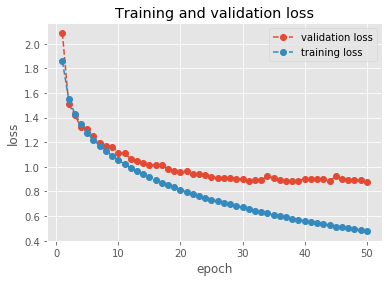

In [52]:
plot_loss(history)